In [14]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [15]:
director = np.load("features_countvec/train_countvec_features_actor_2_name.npy")
df = pd.read_csv("train_dataset.csv")
df = pd.concat([df, pd.DataFrame(director)], axis=1).dropna(subset=["language"]).reset_index()

director_test = np.load("features_countvec/test_countvec_features_actor_2_name.npy")
test = pd.read_csv("test_dataset.csv")
test = pd.concat([test, pd.DataFrame(director_test)], axis=1)
labels = df['imdb_score_binned']

In [16]:
def preproc(df):
    # Fix the genre column

    genres = df['genres'].str.split("|")
    genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

    for x in genres:
        df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

    df.drop(["genres"], axis=1, inplace=True)

    # One hot encode language, country, content_rating
    df = pd.get_dummies(df, columns=["language", "country", "content_rating"], dtype=float)

    ids = df.id
    df = df.iloc[:,2:].select_dtypes(['number'])

    return([df, ids])

In [17]:
df.drop(columns=['imdb_score_binned', 'director_name'], axis=1, inplace=True)
Data, ids_train = preproc(df)
Test, ids_test = preproc(test)

In [18]:
# ensure the one hot encoded columns are all the same and in the same order

train_cols = Data.columns
test_cols = Test.columns
missing_levels = train_cols.difference(test_cols)

for x in missing_levels:
    Test[x] = 0
Test = Test[Data.columns]

In [19]:
Data.columns = Data.columns.astype(str)
Test.columns = Test.columns.astype(str)

In [20]:
Data_copy = Data.copy() # Make a copy to recall the column names after scaling.

Data_scaler = preprocessing.MinMaxScaler() # create scaler
Data_scaler.fit(Data) #fit scaler
Data = Data_scaler.fit_transform(Data)
Data_df = pd.DataFrame(Data, columns = Data_copy.columns)

Test = Data_scaler.fit_transform(Test)
Test_df = pd.DataFrame(Test, columns = Data_copy.columns)

In [21]:
# setup matplotlib 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
#plt.style.use("ggplot")

In [22]:
num_features = 50 # pick a number of feature importances and reasses later

model_rfi = RandomForestClassifier(n_estimators=100) #random forest for finding the important features
model_rfi.fit(Data, labels)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [23]:
best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['num_voted_users', 'num_user_for_reviews', 'duration',
       'num_critic_for_reviews', 'movie_facebook_likes', 'title_year',
       'gross', 'director_facebook_likes', 'actor_3_facebook_likes',
       'cast_total_facebook_likes', 'actor_2_facebook_likes',
       'actor_1_facebook_likes', 'average_degree_centrality',
       'facenumber_in_poster', 'Drama', 'Action', 'Comedy',
       'content_rating_R', 'content_rating_PG-13', 'country_USA',
       'Thriller', 'Horror', 'Biography', 'Romance', 'language_English',
       'Adventure', 'Crime', 'Fantasy', 'Sci-Fi', 'content_rating_PG',
       'country_UK', 'Mystery', 'History', 'War', 'Music', 'Family',
       'Sport', 'Animation', '1847', 'Documentary', 'language_French',
       'Musical', 'content_rating_G', 'country_France', 'country_Germany',
       '356', '1310', 'Western', '1733', '2667'], dtype=object)

In [24]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.06411941, 0.04754182, 0.04038727, 0.03775817, 0.03569056,
       0.03555758, 0.03424721, 0.03321183, 0.03302742, 0.03055263,
       0.02941542, 0.02901751, 0.02770072, 0.01796275, 0.01559696,
       0.00948811, 0.00827823, 0.00805948, 0.00788373, 0.00771041,
       0.00763185, 0.00700964, 0.00700855, 0.006813  , 0.00613952,
       0.00576518, 0.00574223, 0.0055581 , 0.0052758 , 0.00475494,
       0.00434649, 0.00425499, 0.00420982, 0.00395481, 0.00367278,
       0.00342286, 0.00291082, 0.00290559, 0.0023874 , 0.00224344,
       0.00204356, 0.00190093, 0.00182125, 0.00181399, 0.00179217,
       0.00165383, 0.00144938, 0.00144184, 0.00134895, 0.0013273 ])

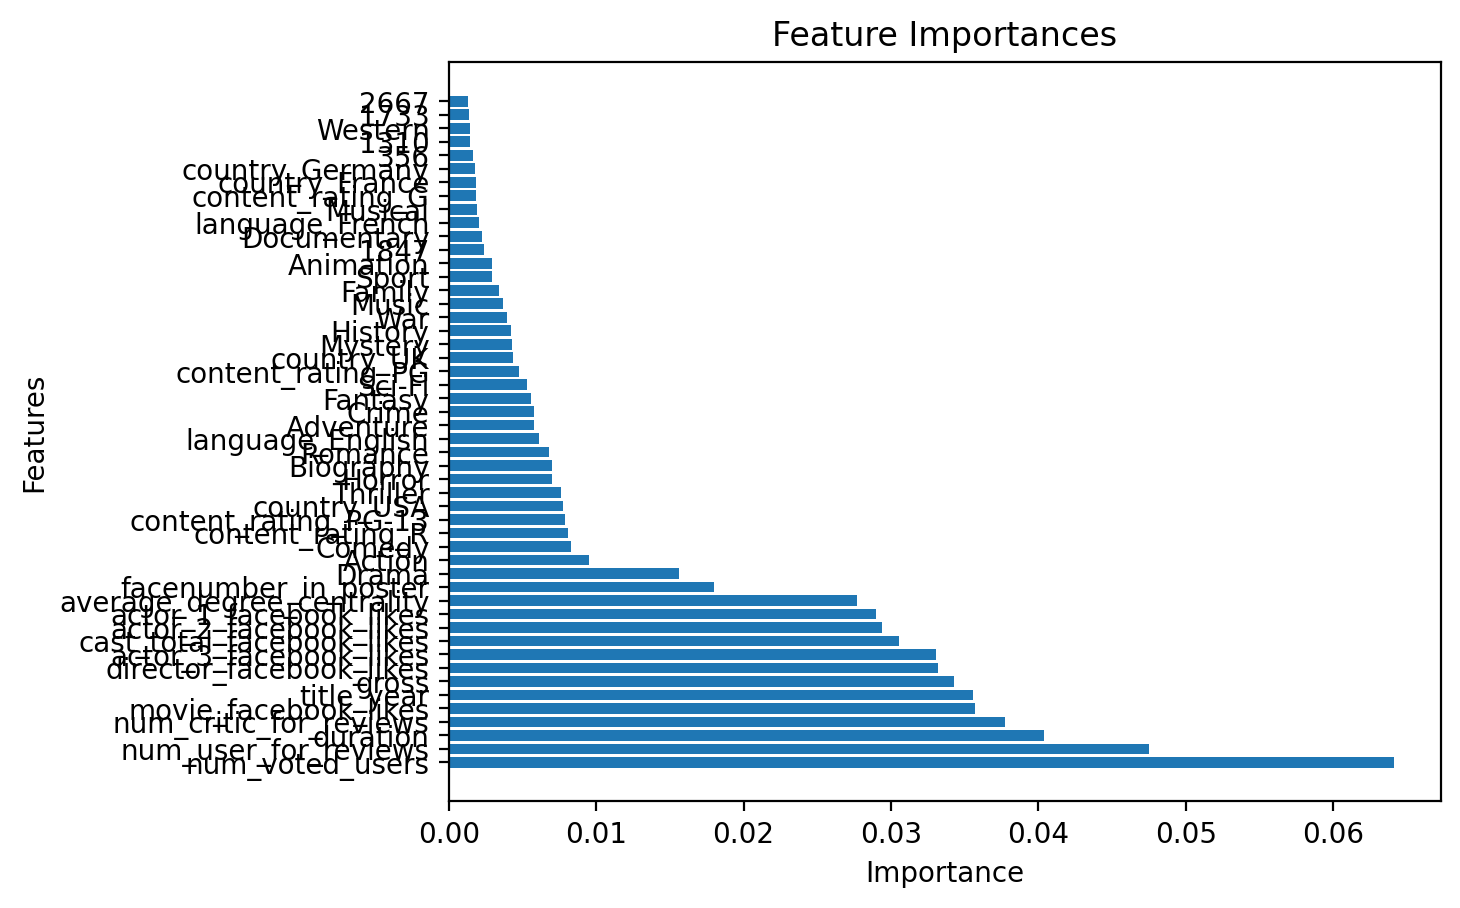

In [25]:
plt.barh(best_features_rfi, feature_importances_rfi)
plt.title('Feature Importances')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# below is how much of the variance each of the best 20 features can explain

In [26]:
D_train_fs = Data[:, fs_indices_rfi[0:50]]
D_test_fs  = Test[:, fs_indices_rfi[0:50]]

In [27]:
perf_metric = "accuracy" 
criterion = ["gini", "entropy"]

cv_method = RepeatedStratifiedKFold(n_splits=3,
                                    n_repeats=3,
                                    random_state=999)

In [28]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF.fit(D_train_fs, labels);

In [29]:
print(f"Best parameters: {gs_RF.best_params_}")
print(f"Best score: {gs_RF.best_score_}")

Best parameters: {'n_estimators': 500, 'max_depth': 16, 'criterion': 'gini'}
Best score: 0.7427017427017426


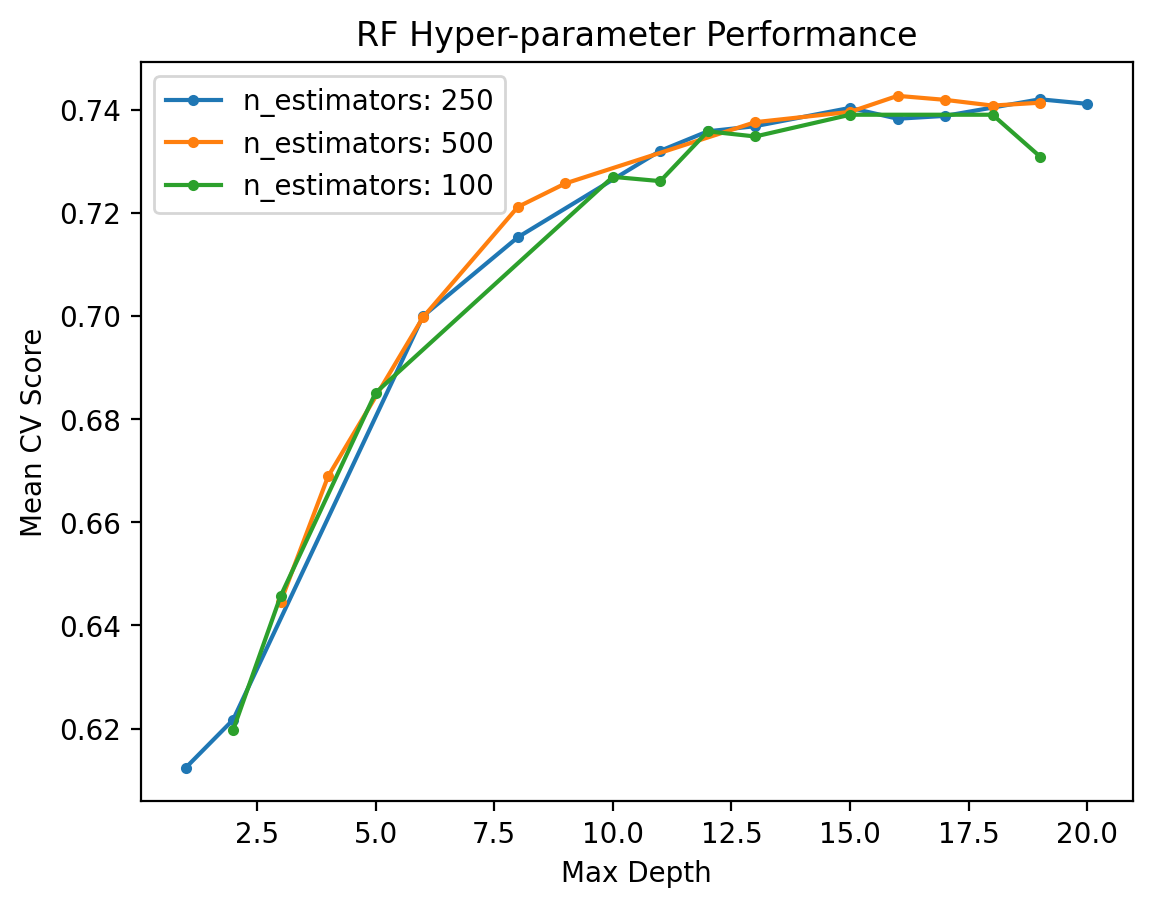

In [30]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']

for i in results_RF['n_estimators'].unique():
    perf = results_RF[results_RF['n_estimators'] == i]
    perf_average = perf.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(perf_average, marker = '.', label = 'n_estimators: ' + str(i))
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("RF Hyper-parameter Performance")
plt.show()

# like before the graph indicates we don't need to search through higher parameters.
# the number of estimators didn't make a huge difference, the 500 and 250 curves are quite similar, 100 estimators 
# has a big jump then behaves like the other curves.

In [31]:
test_pred = gs_RF.predict(D_test_fs)

In [34]:
RF_kaggle = pd.DataFrame({'id':ids_test, 'imdb_score_binned': test_pred})
RF_kaggle.to_csv("results_RF_50cols.csv", index=False)